# Accessing ncSOS with OWSLib

We have an ncSOS server with a [get observation example that works](http://geoport-dev.whoi.edu/thredds/sos/usgs/data2/notebook/1211-AA.cdf?service=SOS&version=1.0.0&request=GetObservation&responseFormat=text%2Fxml%3Bsubtype%3D%22om%2F1.0.0%22&offering=1211-AA&observedProperty=http://mmisw.org/ont/cf/parameter/eastward_sea_water_velocity&procedure=urn:ioos:station:gov.usgs.cmgp:1211-AA):
```
http://geoport-dev.whoi.edu/thredds/sos/usgs/data2/notebook/1211-AA.cdf?service=SOS&version=1.0.0&request=GetObservation&responseFormat=text%2Fxml%3Bsubtype%3D%22om%2F1.0.0%22&offering=1211-AA&observedProperty=http://mmisw.org/ont/cf/parameter/eastward_sea_water_velocity&procedure=urn:ioos:station:gov.usgs.cmgp:1211-AA
```

But can we formulate, request and process this same query (and others like it) using OWSlib?  

In [64]:
%matplotlib inline 
from owslib.sos import SensorObservationService
import pdb
from owslib.etree import etree
import pandas as pd
import datetime as dt
import numpy as np

In [46]:
url = 'http://sdf.ndbc.noaa.gov/sos/server.php?request=GetCapabilities&service=SOS&version=1.0.0'
ndbc = SensorObservationService(url)

In [47]:
# usgs woods hole
# buoy data (single current meter)
url='http://geoport-dev.whoi.edu/thredds/sos/usgs/data2/notebook/1211-AA.cdf'
usgs = SensorObservationService(url)
contents = usgs.contents

In [48]:
usgs.contents

{'network-all': <SosObservationOffering 'urn:ioos:network:gov.usgs.cmgp:all'>,
 'urn_ioos_station_gov.usgs.cmgp_1211-AA': <SosObservationOffering 'urn:ioos:station:gov.usgs.cmgp:1211-AA'>}

In [49]:
off = usgs.offerings[1]
off.name

'urn:ioos:station:gov.usgs.cmgp:1211-AA'

In [50]:
off.response_formats

['text/xml;subtype="om/1.0.0"',
 'text/csv',
 'text/json',
 'text/xml;subtype="om/1.0.0/profiles/ioos_sos/1.0"']

In [51]:
off.observed_properties

['http://mmisw.org/ont/cf/parameter/sea_water_speed',
 'http://mmisw.org/ont/cf/parameter/eastward_sea_water_velocity',
 'http://mmisw.org/ont/cf/parameter/direction_of_sea_water_velocity',
 'http://mmisw.org/ont/fake/parameter/V00_1900',
 'http://mmisw.org/ont/fake/parameter/upr_4001',
 'http://mmisw.org/ont/cf/parameter/northward_sea_water_velocity',
 'http://mmisw.org/ont/fake/parameter/V01_1901']

In [52]:
off.procedures

['urn:ioos:station:gov.usgs.cmgp:1211-AA']

In [53]:
# the get observation request below works.  How can we recreate this using OWSLib?
# http://geoport-dev.whoi.edu/thredds/sos/usgs/data2/notebook/1211-A1H.cdf?service=SOS&version=1.0.0&request=GetObservation&responseFormat=text%2Fxml%3Bsubtype%3D%22om%2F1.0.0%22&offering=1211-A1H&observedProperty=u_1205&procedure=urn:ioos:station:gov.usgs:1211-A1H

In [54]:
#pdb.set_trace()
response = usgs.get_observation(offerings=['1211-AA'],
                                 responseFormat='text/xml;subtype="om/1.0.0"',
                                 observedProperties=['http://mmisw.org/ont/cf/parameter/eastward_sea_water_velocity'],
                                 procedure='urn:ioos:station:gov.usgs:1211-AA')

In [55]:
print(response[0:4000])

b'<?xml version="1.0" encoding="UTF-8"?>\r\n<om:ObservationCollection xmlns:om="http://www.opengis.net/om/1.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:gml="http://www.opengis.net/gml" xmlns:swe="http://www.opengis.net/swe/1.0" xsi:schemaLocation="http://www.opengis.net/om/1.0 http://schemas.opengis.net/om/1.0.0/observation.xsd">\r\n  <gml:description>USGS-CMG time-series data from the Argo Merchant Experiment project, mooring 121 and package 1211-AA. A moored array deployed after the ARGO MERCHANT ran aground on Nantucket Shoals designed to help understand the fate of the spilled oil.</gml:description>\r\n  <gml:name>USGS-CMG time-series data: ARGO_MERCHANT - 121 - 1211-AA</gml:name>\r\n  <gml:boundedBy>\r\n    <gml:Envelope srsName="http://www.opengis.net/def/crs/EPSG/0/4326">\r\n      <!-- overwrite these with your actual offering ROI -->\r\n      <gml:lowerCorner>40.9011116027832 -69.17666625976562</gml:lowerCorner>\r\n 

In [56]:
# usgs woods hole ADCP data
# url='http://geoport-dev.whoi.edu/thredds/sos/usgs/data2/notebook/9111aqd-a.nc'
# adcp = SensorObservationService(url)


In [57]:
root = etree.fromstring(response)

In [58]:
print(root)

<Element {http://www.opengis.net/om/1.0}ObservationCollection at 0x94e2188>


In [59]:
# root.findall(".//{%(om)s}Observation" % root.nsmap )
values = root.find(".//{%(swe)s}values" % root.nsmap )

In [60]:
date_value = np.array( [ (dt.datetime.strptime(d,"%Y-%m-%dT%H:%M:%SZ"),float(v))
                      for d,v in [l.split(',') for l in values.text.split()]] )

In [61]:
ts = pd.Series(date_value[:,1],index=date_value[:,0])

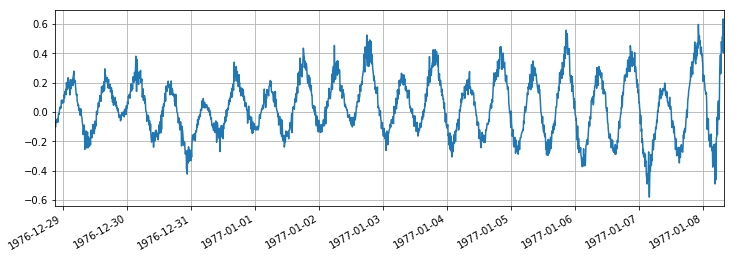

In [72]:
ts.plot(figsize=(12,4), grid='on');

# Now try setting time range via eventTime. 

In [70]:

start = '1977-01-03T00:00:00Z'
stop = '1977-01-07T00:00:00Z'
response = usgs.get_observation(offerings=['1211-AA'],
                                 responseFormat='text/xml;subtype="om/1.0.0"',
                                 observedProperties=['http://mmisw.org/ont/cf/parameter/eastward_sea_water_velocity'],
                                 procedure='urn:ioos:station:gov.usgs:1211-AA',
                                 eventTime='{}/{}'.format(start,stop))

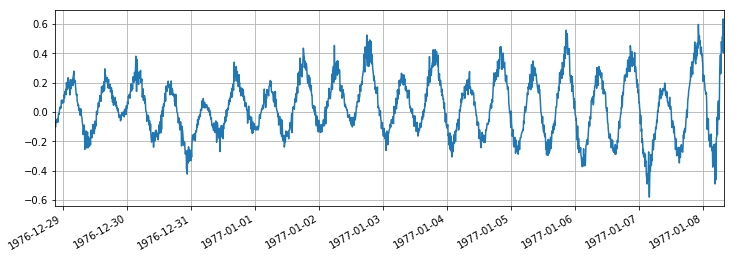

In [73]:
root = etree.fromstring(response)
date_value = np.array( [ (dt.datetime.strptime(d,"%Y-%m-%dT%H:%M:%SZ"),float(v))
                      for d,v in [l.split(',') for l in values.text.split()]] )
ts = pd.Series(date_value[:,1],index=date_value[:,0])
ts.plot(figsize=(12,4), grid='on');

...hmmm, didn't seem to do anything